## Import Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-04-11 12:29:22.533077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 12:29:22.533201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 12:29:22.670260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Extract Image Features

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

2024-04-11 12:29:41.045874: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.42855, expected 3.64542
2024-04-11 12:29:41.045921: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.87036, expected 5.08723
2024-04-11 12:29:41.045931: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.04003, expected 5.2569
2024-04-11 12:29:41.045938: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.22034, expected 5.43722
2024-04-11 12:29:41.045957: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.90026, expected 4.11714
2024-04-11 12:29:41.045965: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.21068, expected 4.42756
2024-04-11 12:29:41.045973: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.92061, expected 5.13748
2024-04-11 12:29:41.045985: E external/local_xla/xla/ser

In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

## Preprocess Text Data

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

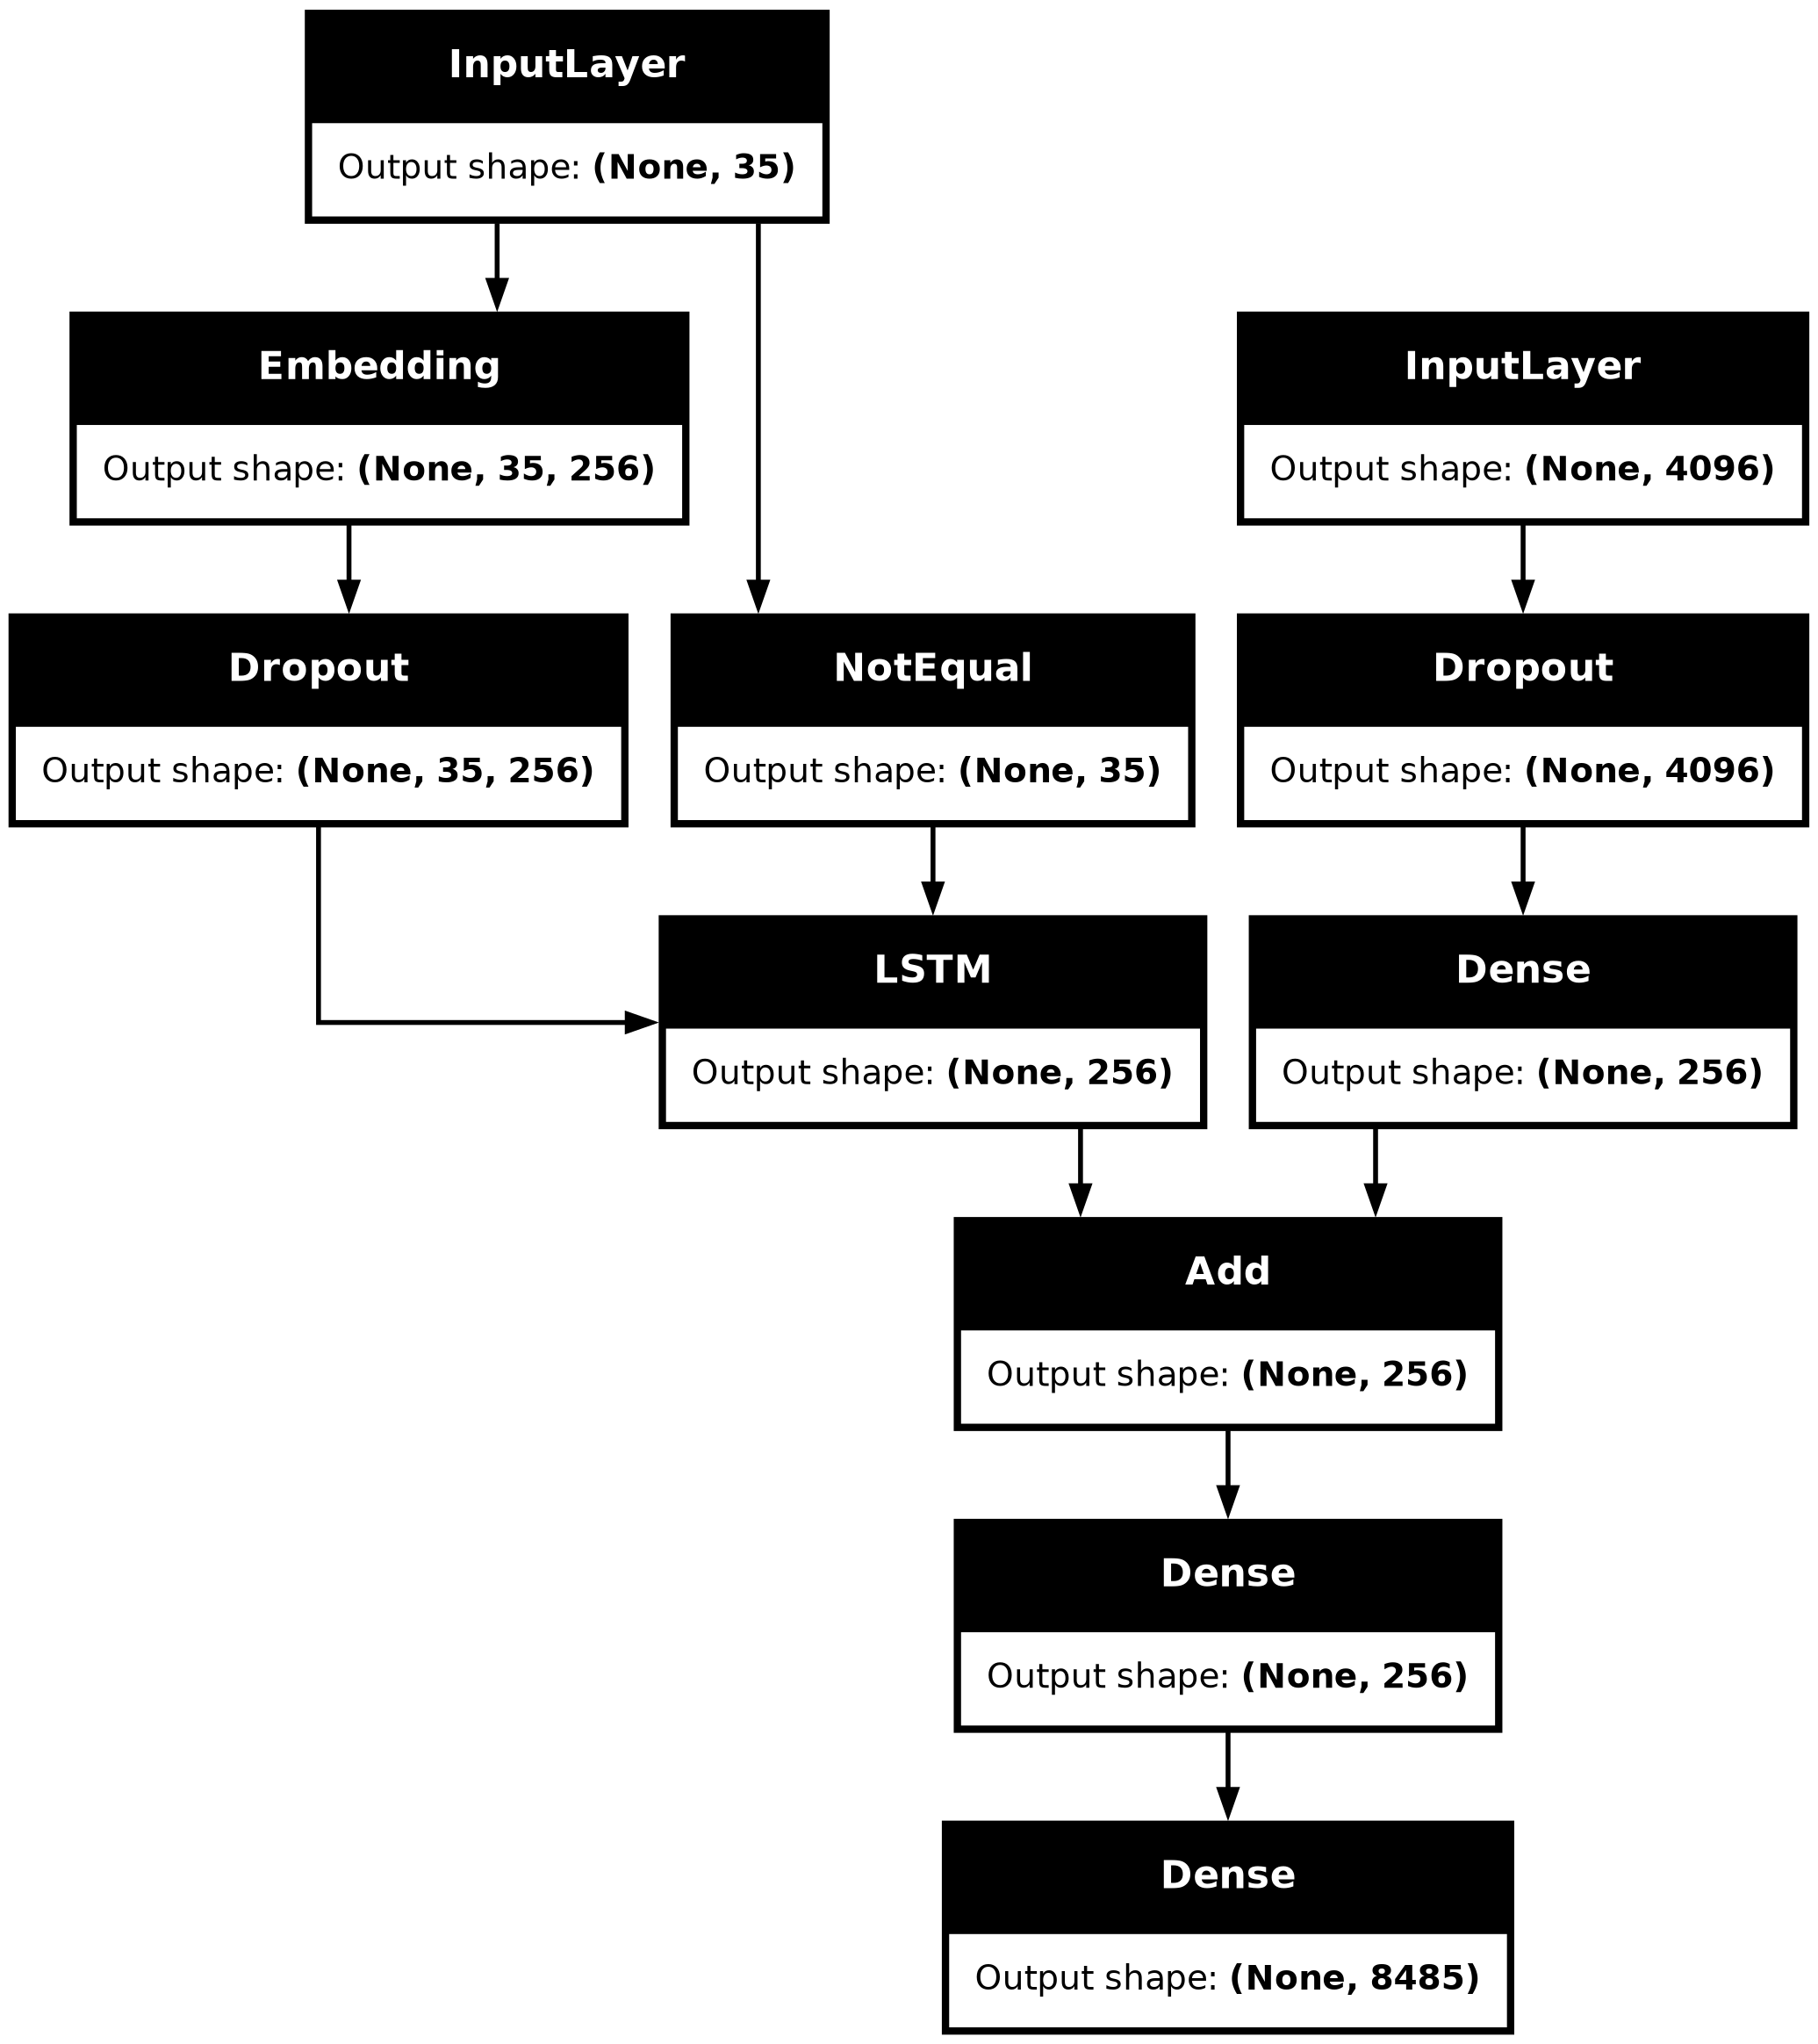

In [23]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)

# Compile the model with accuracy as a metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# plot the model
plot_model(model, show_shapes=True)

In [24]:
# train the model
epochs = 50
batch_size = 32
steps = len(train) // batch_size

# Train the model again
history = {'accuracy': []}  # Initialize history dictionary

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    hist = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    history['accuracy'].append(hist.history['accuracy'])  # Append accuracy for the epoch



227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 265ms/step - accuracy: 0.0748 - loss: 6603.9575
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - accuracy: 0.1092 - loss: 7.6849
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - accuracy: 0.1274 - loss: 6.0536
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - accuracy: 0.1451 - loss: 5.4908
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 262ms/step - accuracy: 0.1545 - loss: 5.3374
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - accuracy: 0.1629 - loss: 5.1954
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - accuracy: 0.1740 - loss: 5.0335
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 262ms/step - accuracy: 0.1825 - loss: 4.8575
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 266ms/step - accuracy: 0.1985 - loss: 4.7547
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - accuracy: 0.2025 - loss: 4.6320
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - accuracy: 0.2089 - loss: 4.4699
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - accuracy: 0.2244 - loss: 4.3938
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 262ms/step - accuracy: 0.230

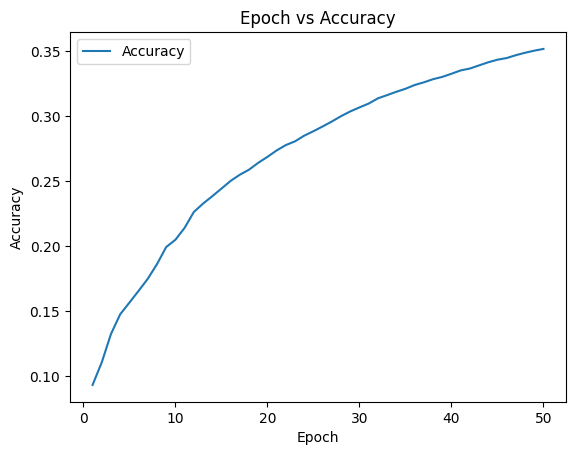

In [25]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), history['accuracy'], label='Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [26]:
# save the model
model.save(WORKING_DIR+'/best_model200.h5')

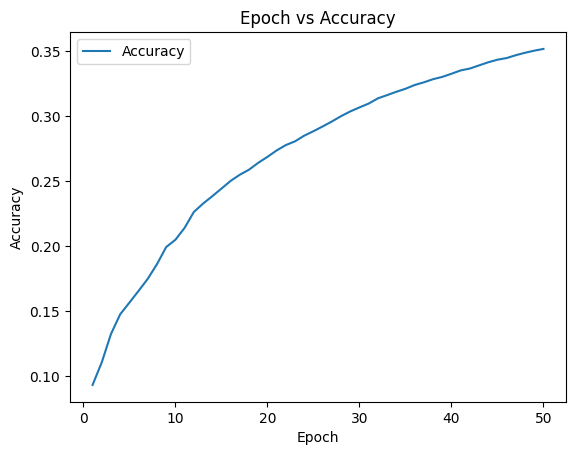

In [27]:
# Plot epoch vs accuracy graph
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), history['accuracy'], label='Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Generate Captions for the Image

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [29]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [30]:
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
pickle.dump(actual, open(os.path.join(WORKING_DIR, 'actual.pkl'), 'wb'))
pickle.dump(predicted, open(os.path.join(WORKING_DIR, 'predicted.pkl'), 'wb'))

  0%|          | 0/810 [00:00<?, ?it/s]

In [31]:
from nltk.translate.bleu_score import corpus_bleu

def calculate_scores(actual, predicted):
    # BLEU scores
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu1, bleu2, bleu3, bleu4

# Load actual and predicted lists from pickle files
with open(os.path.join(WORKING_DIR, 'actual.pkl'), 'rb') as f:
    actual = pickle.load(f)
with open(os.path.join(WORKING_DIR, 'predicted.pkl'), 'rb') as f:
    predicted = pickle.load(f)
    
# Calculate the BLEU scores
bleu1, bleu2, bleu3, bleu4 = calculate_scores(actual, predicted)

# Print the BLEU scores
print("BLEU-1: %f" % bleu1)
print("BLEU-2: %f" % bleu2)
print("BLEU-3: %f" % bleu3)
print("BLEU-4: %f" % bleu4)

BLEU-1: 0.486560
BLEU-2: 0.222398
BLEU-3: 0.129096
BLEU-4: 0.054568


## Visualize the Results

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing in the snow endseq


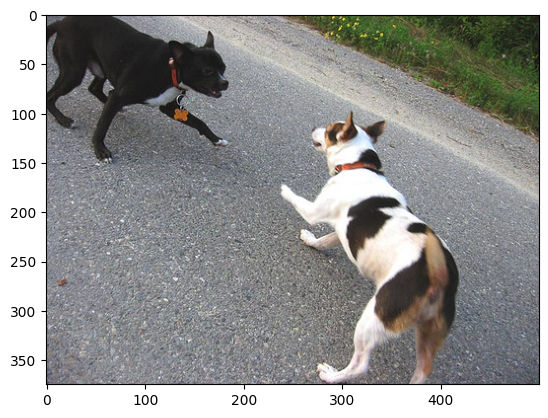

In [33]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq two dogs are playing in the snow endseq


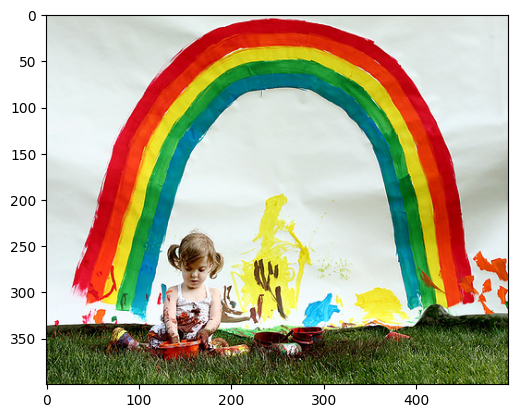

In [34]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two dogs are playing in the snow endseq


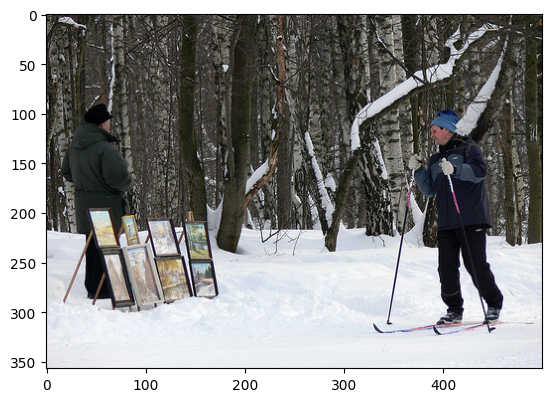

In [35]:
generate_caption("101669240_b2d3e7f17b.jpg")

## Test with Real Image

In [36]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [37]:
image_path = '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq two dogs are playing in the snow endseq'

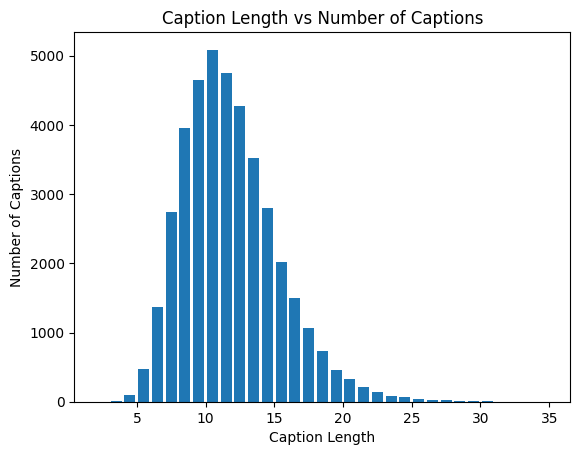

In [38]:
# Get lengths of all captions
caption_lengths = [len(caption.split()) for captions in mapping.values() for caption in captions]

# Plot caption length vs number of captions graph
plt.hist(caption_lengths, bins=range(min(caption_lengths), max(caption_lengths) + 1, 1), rwidth=0.8)
plt.xlabel('Caption Length')
plt.ylabel('Number of Captions')
plt.title('Caption Length vs Number of Captions')
plt.show()


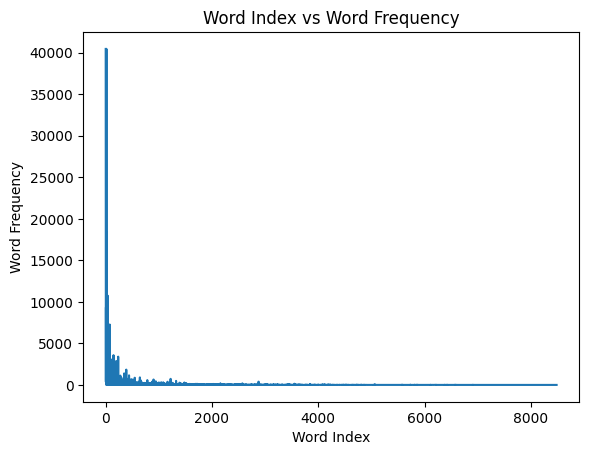

In [39]:
# Get word counts from tokenizer
word_counts = tokenizer.word_counts

# Plot word index vs word frequency graph
plt.plot(range(1, len(word_counts)+1), word_counts.values())
plt.xlabel('Word Index')
plt.ylabel('Word Frequency')
plt.title('Word Index vs Word Frequency')
plt.show()


In [52]:
from nltk.translate.meteor_score import meteor_score

def calculate_meteor(actual, predicted):
    meteor_scores = []
    for i in range(len(actual)):
        meteor_scores.append(meteor_score(actual[i], predicted[i]))  
    return sum(meteor_scores) / len(meteor_scores)

# Load actual and predicted lists from pickle files
with open(os.path.join(WORKING_DIR, 'actual.pkl'), 'rb') as f:
    actual = pickle.load(f)
with open(os.path.join(WORKING_DIR, 'predicted.pkl'), 'rb') as f:
    predicted = pickle.load(f)

# Calculate METEOR score
meteor = calculate_meteor(actual, predicted)
print("METEOR Score:", meteor)

TypeError: descriptor 'lower' for 'str' objects doesn't apply to a 'list' object

In [55]:
from pycocoevalcap.cider.cider import Cider

reference_captions = {
    '0': ['A', 'dog', 'participates', 'in', 'a', 'race', 'while', 'wearing', 'the', 'number', '6']
}

predicted_captions = {
    '0': ['two', 'dogs', 'are', 'playing', 'in', 'the', 'snow', 'each', 'other', 'on', 'the', 'road']
}

# Choose only one predicted caption for each image
predicted_captions_single = {key: [predicted_captions[key][0]] for key in predicted_captions}

# Initialize the CIDEr scorer
cider_scorer = Cider()

# Compute the CIDEr score
cider_score, _ = cider_scorer.compute_score(reference_captions, predicted_captions_single)

print("CIDEr score:", cider_score)


CIDEr score: 0.0


In [54]:
 pip install "git+https://github.com/salaniz/pycocoevalcap.git"

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-t5yngl9t
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-t5yngl9t
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 8.9 MB/s eta 0:00:00:00:01
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=bce85f1d15b97c540e3826a2543f0f90571872213400e3fb4cf40d57146ea02b
  Stored in directory: /tmp/pip-ephem-wheel-cache-pnfsjwxm/wheels/57/de/9f/7aa9ae75f4e4733cc4b66b5c3a65a05de62a28e8111649fee5
Successfully built pycocoevalcap
Note: you may need to restart the kernel to use updated packages.


In [56]:
image_path = '/kaggle/input/testimage/image.jpg'
image = Image.open(img_path)
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq two dogs are playing in the snow endseq'

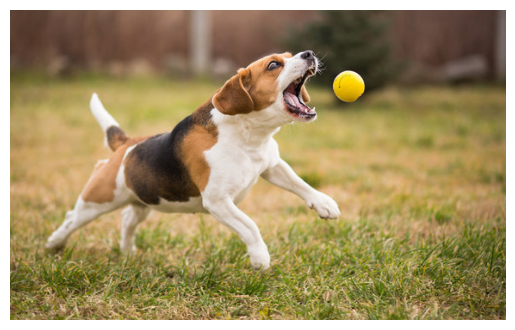

In [57]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()